In [1]:
!python -m spacy download en_core_web_sm

                                              0.0/12.8 MB ? eta -:--:--
                                             0.0/12.8 MB 991.0 kB/s eta 0:00:13
                                              0.2/12.8 MB 1.8 MB/s eta 0:00:07
                                              0.2/12.8 MB 1.9 MB/s eta 0:00:07
     -                                        0.3/12.8 MB 2.0 MB/s eta 0:00:07
     -                                        0.4/12.8 MB 1.8 MB/s eta 0:00:07
     -                                        0.5/12.8 MB 1.9 MB/s eta 0:00:07
     --                                       0.7/12.8 MB 2.1 MB/s eta 0:00:06
     --                                       0.8/12.8 MB 2.1 MB/s eta 0:00:06
     --                                       0.9/12.8 MB 2.2 MB/s eta 0:00:06
     ---                                      1.1/12.8 MB 2.4 MB/s eta 0:00:05
     ---                                      1.2/12.8 MB 2.4 MB/s eta 0:00:05
     ----                                     1.4/12.8 MB 

In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [3]:
NER = spacy.load("en_core_web_sm")
NER.max_length = 4054751

In [4]:
import os

In [5]:
all_books = [books for books in os.scandir('data') if '.txt' in books.name]

In [6]:
all_books

[<DirEntry 'Book 1.txt'>, <DirEntry 'ram.txt'>, <DirEntry 'ram2.txt'>]

In [7]:
book = all_books[2]
book_text = open(book).read()
book_doc = NER(book_text)

In [8]:
displacy.render(book_doc[0:2000], style="ent",jupyter=True)

In [9]:
character_df = pd.read_csv("ramayan_ch.csv")

In [10]:
sent_entity_df = []
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence":sent,"entities": entity_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

In [11]:
sent_entity_df

,sentence,entities
0,"(BOOK, II, \n, AYODHYA, KANDA, \n, CHAPTER, X,...","[CHAPTER X, Prince Rama, Bharata, Shatrughna]"
1,"(Enjoying, abundant, hospitality, and, held, b...","[Ashwapati, two]"
2,"(Satisfied, with, the, love, and, entertainmen...",[daily]
3,"(The, four, sons, of, the, aged, king, were, a...","[four, four]"
4,"(Shri, Rama, ,, the, eternal, Purusha,1, the, ...","[Shri Rama, Ravana]"
...,...,...
19584,"(The, Celestial, Beings, rejoice, in, the, und...","[Celestial Beings, Ramayana, Ancestors]"
19585,"(Those, who, ,, in, \n, devotion, ,, transcrib...","[Rama, Rishi Valmiki, Brahma]"
19586,"(The, hearing, of, this, rare, and, beautiful,...",[supreme felicity]
19587,"(This, narrative, which, promotes, long, life,...",[]


In [12]:
def filter_entity(ent_list,character_df):
    return [ent for ent in ent_list
           if ent in list(character_df.character)]


In [13]:
filter_entity(["Rama","Ravana","Lakshmana"],character_df)

['Rama', 'Ravana', 'Lakshmana']

In [14]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x : filter_entity(x,character_df))

sent_entity_df_filtered = sent_entity_df[sent_entity_df["character_entities"].map(len) >0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
0,"(BOOK, II, \n, AYODHYA, KANDA, \n, CHAPTER, X,...","[CHAPTER X, Prince Rama, Bharata, Shatrughna]","[Bharata, Shatrughna]"
4,"(Shri, Rama, ,, the, eternal, Purusha,1, the, ...","[Shri Rama, Ravana]",[Ravana]
6,"(Unequalled, in, beauty, ,, brave, and, chival...","[Rama, the1]",[Rama]
15,"(Seeing, his, illustrious, son, manifesting, t...","[Dasaratha, years]",[Dasaratha]
16,"(I, desire, to, see, Rama, \n, crowned, while,...",[Rama],[Rama]
17,"(This, inclination, grew, in, the, mind, of, t...",[Rama],[Rama]
19,"(Then, that, great, sovereign, summoning, his,...",[Rama],[Rama]
20,"(At, that, tune, ,, inauspicious, portents, ap...",[Rama],[Rama]
21,"(Filled, with, affection, for, his, subjects, ...","[Rama, the hour]",[Rama]
25,"(King, \n, Dasaratha, occupying, the, throne, ...",[Dasaratha],[Dasaratha]


In [15]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [16]:
relationship_df = pd.DataFrame(relationships)

In [17]:
relationship_df

,source,target
0,Bharata,Shatrughna
1,Shatrughna,Ravana
2,Ravana,Rama
3,Ravana,Rama
4,Ravana,Rama
...,...,...
24113,Kaushalya,Rama
24114,Rama,Lakshmana
24115,Lakshmana,Kaikeyi
24116,Kaikeyi,Bharata


In [18]:
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df


,source,target
0,Bharata,Shatrughna
1,Ravana,Shatrughna
2,Rama,Ravana
3,Rama,Ravana
4,Rama,Ravana
...,...,...
24113,Kaushalya,Rama
24114,Lakshmana,Rama
24115,Kaikeyi,Lakshmana
24116,Bharata,Kaikeyi


In [19]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [20]:
relationship_df

,source,target,value
0,Bharata,Shatrughna,119
1,Ravana,Shatrughna,12
2,Rama,Ravana,1840
3,Dasaratha,Rama,491
4,Bharata,Rama,670
...,...,...,...
168,Bharata,Hanuman,44
169,Angada,Kaikeyi,6
170,Bibishana,Shatrughna,5
171,Shatrughna,Sugriva,17


In [21]:
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

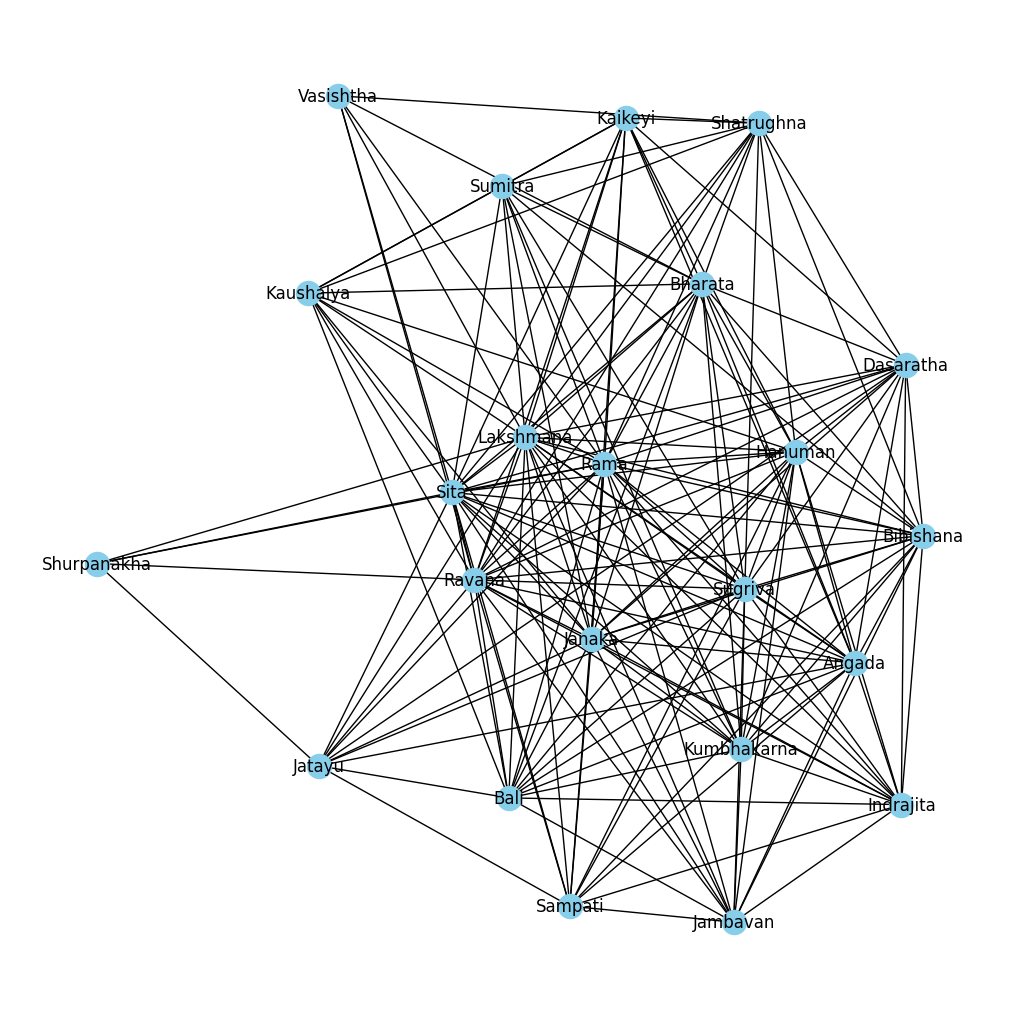

In [22]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [46]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="1000px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')
net.repulsion()
net.from_nx(G)
net.show("RAMAYAN.html")

RAMAYAN.html


In [47]:
drgree_dict = nx.degree_centrality(G)
drgree_dict 

{'Bharata': 0.7727272727272727,
 'Shatrughna': 0.5909090909090909,
 'Ravana': 0.9545454545454546,
 'Rama': 1.0,
 'Dasaratha': 0.6818181818181819,
 'Sumitra': 0.5,
 'Sita': 1.0,
 'Lakshmana': 1.0,
 'Vasishtha': 0.2727272727272727,
 'Kaikeyi': 0.5454545454545454,
 'Kaushalya': 0.5,
 'Janaka': 0.8636363636363636,
 'Bali': 0.6818181818181819,
 'Sugriva': 0.8181818181818182,
 'Bibishana': 0.7727272727272727,
 'Jatayu': 0.5,
 'Kumbhakarna': 0.6818181818181819,
 'Sampati': 0.5454545454545454,
 'Shurpanakha': 0.2272727272727273,
 'Angada': 0.7727272727272727,
 'Hanuman': 0.8181818181818182,
 'Jambavan': 0.5909090909090909,
 'Indrajita': 0.6363636363636364}

In [48]:
def bar(data):
    degree_df = pd.DataFrame.from_dict(data ,orient='index', columns=['centrality'])
    degree_df.sort_values('centrality',ascending=False)[0:9].plot(kind='bar')

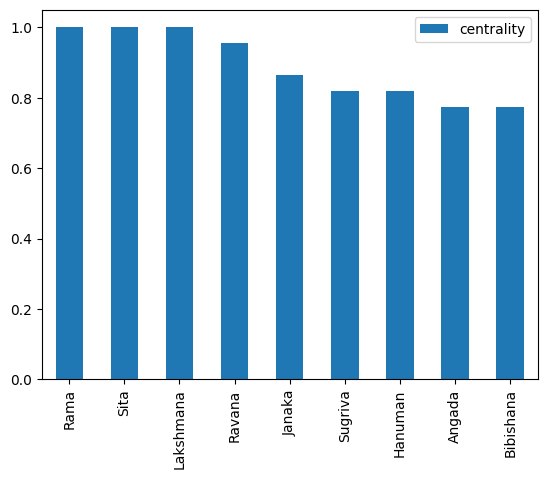

In [49]:
bar(drgree_dict)

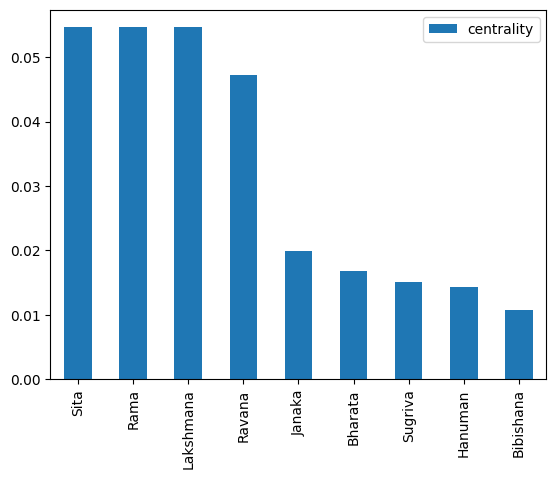

In [50]:
betweenness_dict = nx.betweenness_centrality(G)
bar(betweenness_dict)

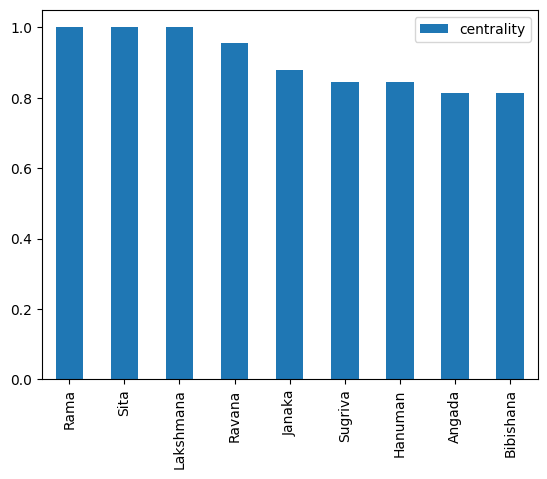

In [51]:
closeness_dict = nx.closeness_centrality(G)
bar(closeness_dict)

In [52]:
import community as cummunity_louvain

In [53]:
communities = cummunity_louvain.best_partition(G)

In [54]:
communities

{'Bharata': 1,
 'Shatrughna': 1,
 'Ravana': 1,
 'Rama': 1,
 'Dasaratha': 1,
 'Sumitra': 1,
 'Sita': 1,
 'Lakshmana': 1,
 'Vasishtha': 1,
 'Kaikeyi': 1,
 'Kaushalya': 1,
 'Janaka': 0,
 'Bali': 0,
 'Sugriva': 0,
 'Bibishana': 0,
 'Jatayu': 1,
 'Kumbhakarna': 0,
 'Sampati': 0,
 'Shurpanakha': 1,
 'Angada': 0,
 'Hanuman': 0,
 'Jambavan': 0,
 'Indrajita': 0}

In [55]:
nx.set_node_attributes(G, communities, 'group')

In [56]:
com_net = Network(notebook= True, width='1920px', height='1080px',bgcolor='#222222', font_color='white')
com_net.repulsion()
com_net.from_nx(G)
com_net.show('RAMAYAN_comunity.html')

RAMAYAN_comunity.html


In [58]:
communities_hard_filter = {'Bharata': 0,
 'Shatrughna': 0,
 'Ravana': 2,
 'Rama': 0,
 'Dasaratha': 0,
 'Sumitra': 0,
 'Sita': 0,
 'Lakshmana': 0,
 'Vasishtha': 3,
 'Kaikeyi': 0,
 'Kaushalya': 0,
 'Janaka': 3,
 'Bali': 4,
 'Sugriva': 4,
 'Bibishana': 2,
 'Jatayu': 1,
 'Kumbhakarna': 2,
 'Sampati': 1,
 'Shurpanakha': 2,
 'Angada': 4,
 'Hanuman': 4,
 'Jambavan': 4,
 'Indrajita': 2}

In [59]:
nx.set_node_attributes(G, communities_hard_filter, 'group')

In [63]:
com_net2 = Network(notebook= True,cdn_resources='remote', width='1920px', height='1080px',bgcolor='#222222', font_color='white')
com_net2.repulsion()
com_net2.from_nx(G)
com_net2.show('RAMAYAN_comunity_hard_filter.html')


RAMAYAN_comunity_hard_filter.html
